**Definizione problema**
* Griglia di dimensione NxN
* M oggetti posizionati nella griglia, ogni oggetto ha un peso. Superato una certa soglia, il giocatore impiega più tempo a compiere un turno (e.g. sopra 50 kg, per eseguire uno step impiega due turni)
* A partire da una starting position, l'aggente deve raccogliere gli oggetti minimizzando il numero di passi

In [1]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# Dimensione della griglia
grid_size = (10, 10)
starting_position = (0, 0)

# Posizioni degli oggetti e i loro pesi
objects = [(1, 1), (4, 4), (5, 5)]
weights = [30, 5, 5]  # Pesi corrispondenti agli oggetti
weight_threshold = 30

# Numero di elementi da raccogliere (predefinito dalle posizioni)
num_elements = len(objects)

# Distanza di Manhattan
def manhattan_distance(pos1, pos2):
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

# Funzione per calcolare la lunghezza del percorso
def evaluate(individual, positions, weights, weight_threshold):
    #Individual: permutazione degli indici
    #Positions: posizioni degli oggetti
    #Weights: pesi degli oggetti
    #Weight_threshold: soglia di peso per raddoppiare la distanza

    total_weight = 0
    distance = manhattan_distance(starting_position, positions[individual[0]])
    total_weight += weights[individual[0]]

    for i in range(len(individual) - 1):
        if total_weight >= weight_threshold:
            distance += 2 * manhattan_distance(positions[individual[i]], positions[individual[i + 1]])
        else:
            distance += manhattan_distance(positions[individual[i]], positions[individual[i + 1]])
        total_weight += weights[individual[i + 1]]

    return distance,

# Definizione del tipo di problema e fitness
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Registrazione delle funzioni genetiche
toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(num_elements), num_elements) #permutazione casuale degli indici
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Funzioni di crossover e mutazione
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.02)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate, positions=objects, weights=weights, weight_threshold=weight_threshold)

# Parametri dell'algoritmo genetico
population_size = 10
num_generations = 500
cxpb, mutpb = 0.7, 0.2

# Creazione della popolazione iniziale
population = toolbox.population(n=population_size)

# Algoritmo genetico
algorithms.eaSimple(population, toolbox, cxpb, mutpb, num_generations, 
                    stats=tools.Statistics(lambda ind: ind.fitness.values),
                    halloffame=tools.HallOfFame(1),
                    verbose=False)

# Risultati
best_individual = tools.selBest(population, 1)[0]
best_route = [objects[i] for i in best_individual]
best_distance = evaluate(best_individual, objects, weights, weight_threshold=weight_threshold)[0]


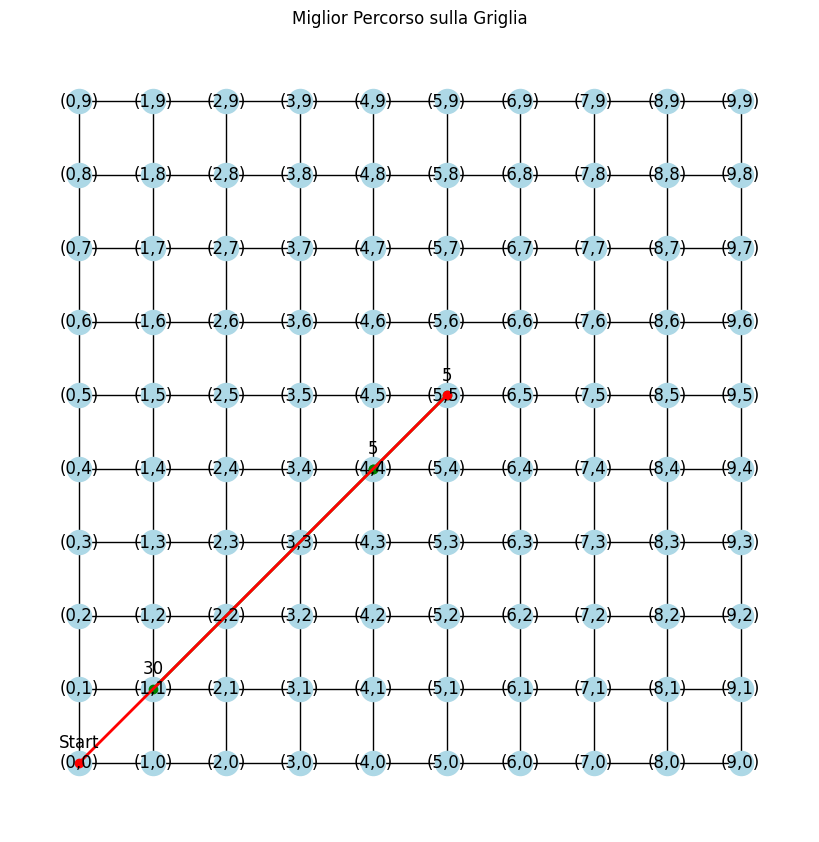

Starting position (0, 0)
Miglior percorso: [(5, 5), (4, 4), (1, 1)]
Distanza del miglior percorso: 18


In [2]:
def plot_grid(grid_size, objects, weights, best_route):
    G = nx.grid_2d_graph(grid_size[0], grid_size[1])
    
    pos = dict((n, n) for n in G.nodes())
    labels = dict(((i, j), f'({i},{j})') for i, j in G.nodes())

    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, node_color='lightblue', with_labels=False, node_size=300)
    nx.draw_networkx_labels(G, pos, labels=labels)
    
    # Disegnare gli oggetti con i loro pesi
    for obj, weight in zip(objects, weights):
        plt.scatter(*obj, color='red', s=200)
        plt.text(obj[0], obj[1] + 0.15, str(weight), fontsize=12, ha='center', va='bottom', color='black')

    # Disegnare la posizione iniziale
    plt.scatter(0, 0, color='red', s=200)
    plt.text(0, 0 + 0.15, 'Start', fontsize=12, ha='center', va='bottom', color='black')

    # Disegnare il percorso
    path = best_route
    for i in range(len(path) - 1):
        p1, p2 = path[i], path[i + 1]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='green', linewidth=2, marker='o', markersize=6)

    # Disegnare il primo segmento di percorso dallo starting position
    first_point = path[0]
    plt.plot([starting_position[0], first_point[0]], [starting_position[1], first_point[1]], color='red', linewidth=2, marker='o', markersize=6)

    plt.title("Miglior Percorso sulla Griglia")
    plt.show()

# Uso della funzione modificata
plot_grid(grid_size, objects, weights, best_route)
print("Starting position", starting_position)
print("Miglior percorso:", best_route)
print("Distanza del miglior percorso:", best_distance)
